In [2]:
!git clone https://github.com/Global-Classroom-Scattering-Theory/Application-of-Neural-networks-to-amplitude-analysis.git ./ANNProject

fatal: destination path './ANNProject' already exists and is not an empty directory.


In [3]:
import os
path=os.path.expanduser("./ANNProject/dataset/")

In [4]:
import glob
import pandas as pd
import os

dfs =[]

for filename in sorted(glob.glob(path+"ln*.csv")):

    print(filename)
    dfs.append(pd.read_csv(filename,sep=";"))    

    
data=pd.concat(dfs)    

./ANNProject/dataset/ln200k65bins_part_01.csv
./ANNProject/dataset/ln200k65bins_part_02.csv
./ANNProject/dataset/ln200k65bins_part_03.csv
./ANNProject/dataset/ln200k65bins_part_04.csv
./ANNProject/dataset/ln200k65bins_part_05.csv
./ANNProject/dataset/ln200k65bins_part_06.csv
./ANNProject/dataset/ln200k65bins_part_07.csv
./ANNProject/dataset/ln200k65bins_part_08.csv
./ANNProject/dataset/ln200k65bins_part_09.csv
./ANNProject/dataset/ln200k65bins_part_10.csv
./ANNProject/dataset/ln200k65bins_part_11.csv
./ANNProject/dataset/ln200k65bins_part_12.csv
./ANNProject/dataset/ln200k65bins_part_13.csv
./ANNProject/dataset/ln200k65bins_part_14.csv
./ANNProject/dataset/ln200k65bins_part_15.csv
./ANNProject/dataset/ln200k65bins_part_16.csv
./ANNProject/dataset/ln200k65bins_part_17.csv
./ANNProject/dataset/ln200k65bins_part_18.csv
./ANNProject/dataset/ln200k65bins_part_19.csv
./ANNProject/dataset/ln200k65bins_part_20.csv
./ANNProject/dataset/ln200k65bins_part_21.csv
./ANNProject/dataset/ln200k65bins_

In [5]:
data.shape

(200000, 151)

In [6]:
import numpy as np

fulldataset = data

lowe=4.251 #4.101 #4.251
upe=4.379 #4.399 #4.379
widthe=0.002

longCols=["M22Sign","RS1","RS2","RS3","RS4",]
floatCols=[col for col in fulldataset.columns if col not in longCols]
fulldataset[longCols]=fulldataset[longCols].astype("long")
fulldataset[floatCols]=fulldataset[floatCols].astype("float32")
fulldataset=fulldataset[(fulldataset.RS3==4) | (fulldataset.RS3==2)]

hyperparam_cols=["p0","p1","b0","b1","M11","M22","M12SQ","M22Sign"
                 ,"Re1","Im1","RS1","Re2","Im2","RS2","Re3","Im3","RS3","Re4","Im4","RS4"]
hyperparams=fulldataset[hyperparam_cols]


x_cols=[col for col in fulldataset.columns if col not in hyperparam_cols]
e=[energy for energy in x_cols if energy[:4]=="_sig"]
e=[float(energy.split("_")[2]) for energy in e]
e=np.array([energy for energy in e if energy<=upe and energy>=lowe])
# sig_energies=["sig_"+str(energy) for energy in e]
# bkg_energies=["bkg_"+str(energy) for energy in e]
sig_c_energies=["_sig_"+str(energy) for energy in e]
bkg_c_energies=["_bkg_"+str(energy) for energy in e]

X_c=fulldataset[sig_c_energies].values+fulldataset[bkg_c_energies].values # energy resolved
# X_p=fulldataset[sig_energies].values+fulldataset[bkg_energies].values # perfect resolution
Y=np.ravel(fulldataset["classes"])

In [7]:
#  noise 
import numpy as np
import pandas as pd

mu, sigma = 0, 1 # mean and standard deviation
noiseStd = 0.05

dataX_sig = fulldataset[sig_c_energies].values
dataX_bkg = fulldataset[bkg_c_energies].values
noise = np.zeros(dataX_sig.shape)
print(dataX_sig.shape)
for i in range(dataX_sig.shape[0]):
    noise[i] = np.random.normal(mu, sigma, size=(65)) * dataX_sig[i, :].max() * noiseStd

X_noise = dataX_sig + noise
X_completed=X_noise+fulldataset[bkg_c_energies].values # energy resolved


# X = X_c
print(X_c.shape, X_completed.shape, Y.shape)

(200000, 65)
(200000, 65) (200000, 65) (200000,)


In [8]:
from sklearn.preprocessing import minmax_scale

X_scaled = minmax_scale(X_completed, axis=1)

In [9]:
from tensorflow.keras.utils import to_categorical

Yenc=to_categorical(Y)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Yenc, test_size=0.3,random_state=1)

In [11]:
X_train.shape

(140000, 65)

In [12]:
# import tensorflow
# tensorflow.compat.v1.disable_v2_behavior()

import tensorflow as tf    
tf.compat.v1.disable_v2_behavior() # <-- HERE !

# Import `Sequential` from `keras.models`
from tensorflow.keras.models import Sequential

# Import `Dense` from `keras.layers`
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

def makeModel(dropout=False):
# Initialize the constructor
    model = Sequential()

# Add an input layer 
    model.add(Dense(400, activation='relu', input_shape=(65,)))
    if dropout:
        model.add(Dropout(.2))
# Add one hidden layer 
    model.add(Dense(200, activation='relu'))
    if dropout:
        model.add(Dropout(.5))
# # Add one hidden layer 
#     model.add(Dense(200, activation='relu'))
#     if dropout:
#         model.add(Dropout(.2))

# Add an output layer 
    model.add(Dense(4, activation='softmax'))
    return model

model=makeModel()
model.summary()

Instructions for updating:
non-resource variables are not supported in the long term
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               26400     
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dense_2 (Dense)             (None, 4)                 804       
                                                                 
Total params: 107,404
Trainable params: 107,404
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
history=model.fit(X_train, Y_train,epochs=100,batch_size=1024, validation_split=.25, verbose=1)

Train on 105000 samples, validate on 35000 samples
Epoch 1/100
103424/105000 [============================>.] - ETA: 0s - loss: 0.5618 - acc: 0.7808

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


105000/105000 [==============================] - 2s 23us/sample - loss: 0.5583 - acc: 0.7822 - val_loss: 0.3453 - val_acc: 0.8662
Epoch 2/100
105000/105000 [==============================] - 2s 21us/sample - loss: 0.3022 - acc: 0.8854 - val_loss: 0.2924 - val_acc: 0.8890
Epoch 3/100
105000/105000 [==============================] - 2s 21us/sample - loss: 0.2659 - acc: 0.8985 - val_loss: 0.2584 - val_acc: 0.8988
Epoch 4/100
105000/105000 [==============================] - 2s 21us/sample - loss: 0.2430 - acc: 0.9058 - val_loss: 0.2461 - val_acc: 0.9053
Epoch 5/100
105000/105000 [==============================] - 2s 21us/sample - loss: 0.2317 - acc: 0.9092 - val_loss: 0.2419 - val_acc: 0.9057
Epoch 6/100
105000/105000 [==============================] - 2s 20us/sample - loss: 0.2199 - acc: 0.9137 - val_loss: 0.2200 - val_acc: 0.9129
Epoch 7/100
105000/105000 [==============================] - 2s 20us/sample - loss: 0.2132 - acc: 0.9163 - val_loss: 0.2204 - val_acc: 0.9130
Epoch 8/100
105000

In [14]:
import pandas as pd
weight_ds=pd.read_csv(path+"boot_weight.csv",sep=";")
all_ds=pd.read_csv(path+"boot_all.csv",sep=";")
kp_ds=pd.read_csv(path+"boot_kp.csv",sep=";")

In [15]:
from sklearn.preprocessing import minmax_scale

y_pred_weight=model.predict(minmax_scale(weight_ds, axis=1))

y_pred_all=model.predict(minmax_scale(all_ds, axis=1))

y_pred_kp=model.predict(minmax_scale(kp_ds, axis=1))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [16]:
lab_weight=y_pred_weight.argmax(axis=1)
lab_all=y_pred_all.argmax(axis=1)
lab_kp=y_pred_kp.argmax(axis=1)

In [18]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 5.3 MB/s 


In [28]:
import shap

# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

explainer = shap.DeepExplainer(
    (model.layers[0].input, model.layers[-1].output), background
)

row=4
print("Class number prediction: "+str(Y_test[row].argmax(axis=0)))
examples = X_test[row:row+1]

shap_values = explainer.shap_values(examples) # <-- HERE !
feature_names = data.columns[20:-1-65]
class_number = 0
sample_number = 0

# print the JS visualization code to the notebook
shap.initjs()

shap.force_plot(
    explainer.expected_value[class_number], shap_values[class_number][sample_number], feature_names=feature_names
)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Class number prediction: 0


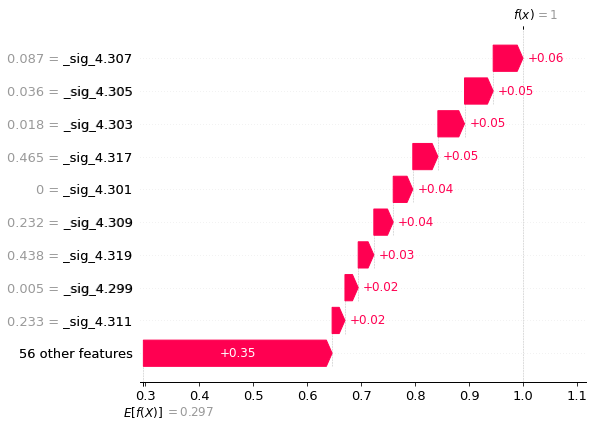

In [29]:

explaining = shap.Explanation(values=shap_values[class_number][sample_number], 
                 base_values=explainer.expected_value[class_number], 
                 data=X_test[row], 
                 feature_names=data.columns[20:-1-65])
shap.waterfall_plot(explaining, max_display=10)

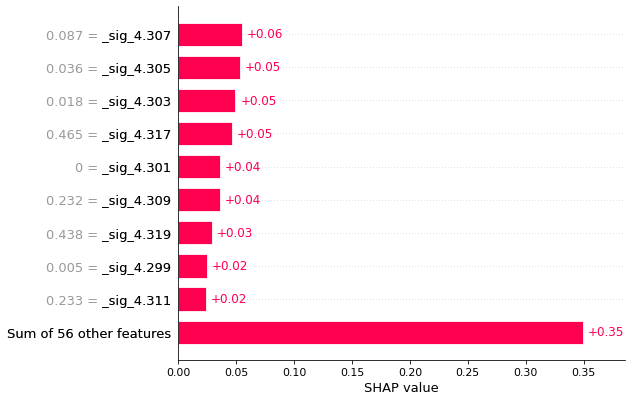

In [30]:
shap.plots.bar(explaining)

In [ ]:
map1={
    3:"v|4",
    2:"v|2",
    1:"b|4",
    0:"b|2"
    }
mapColor={
    3: "#D61D28",
    2: "#2CA02C",
    1: "#FF7F0E",
    0: "#1F77B4"
}

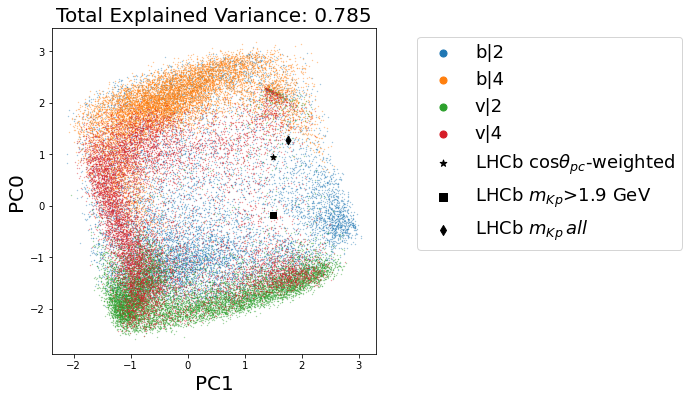

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

saveData = False

npc=2
pca = PCA(n_components=npc)
pcs=[]
for ipc in range(npc):
  pcs.append("PC"+str(ipc))
inputX_df_trans=pca.fit_transform(X_scaled)
inputX_df_trans=pd.DataFrame(inputX_df_trans,columns=pcs)
inputY_df=pd.Series(Y)

weight_scaled = minmax_scale(weight_ds, axis=1)
kp_scaled = minmax_scale(kp_ds, axis=1)
all_scaled = minmax_scale(all_ds, axis=1)

expdata_pc4312_trans=pca.transform(weight_scaled)
expdata_pc4312_trans=pd.DataFrame(expdata_pc4312_trans, columns=pcs)
expdata_pc4312_kp_trans=pca.transform(kp_scaled)
expdata_pc4312_kp_trans=pd.DataFrame(expdata_pc4312_kp_trans,columns=pcs)
expdata_pc4312_all_trans=pca.transform(all_scaled)
expdata_pc4312_all_trans=pd.DataFrame(expdata_pc4312_all_trans,columns=pcs)

def plotPCpair(ax,ipc,jpc,restricted,markersize,bbox):
  #cmap = mpl.cm.get_cmap("viridis")
  for y in [0,1,2,3]:
    tmp=inputX_df_trans[inputY_df==y]
    tmp=tmp.sample(10000)
    ax.scatter(tmp[ipc],tmp[jpc],s=markersize,alpha=0.6,label=map1[y], color=mapColor[y])#cmap(y*1.0/(len(inputY.unique())-1)))

  datapoint_to_display = 1 
  ax.scatter(expdata_pc4312_trans[ipc].iloc[datapoint_to_display],expdata_pc4312_trans[jpc].iloc[datapoint_to_display],c='black',marker="*",label="LHCb "+r"cos$\theta_{pc}$-weighted")
  ax.scatter(expdata_pc4312_kp_trans[ipc].iloc[datapoint_to_display],expdata_pc4312_kp_trans[jpc].iloc[datapoint_to_display],c='black',marker="s",label=r"LHCb $m_{Kp}$>1.9 GeV")
  ax.scatter(expdata_pc4312_all_trans[ipc].iloc[datapoint_to_display],expdata_pc4312_all_trans[jpc].iloc[datapoint_to_display],c='black',marker="d",label="LHCb $m_{Kp}\, all$")
  ax.set_title("Total Explained Variance: {:.3f}".format(pca.explained_variance_ratio_.sum()),size=20)
  ax.set_xlabel(ipc,size=20)
  ax.set_ylabel(jpc,size=20)

  if restricted:
    ax.set_ylim(1.3,1.7)
    ax.set_xlim(1.5,2.2)
    # ax.set_ylim(0.25,0.55)
    # ax.set_xlim(-4,-2.5)

  leg=ax.legend(prop={"size":18}, bbox_to_anchor=bbox)
  for handles in leg.legendHandles:
    handles._sizes = [50]
    handles.set_alpha(1)

fig,ax=plt.subplots(1,1,figsize=(12,6))
plotPCpair(ax,"PC1","PC0",False,0.1,(1.1, 1))
plt.gcf().subplots_adjust(right=0.5)
if saveData:
  fig.savefig(imageFolder+"/"+"pca_pc0vspc1"+saveTag+".pdf")
  fig.savefig(imageFolder+"/"+"pca_pc0vspc1"+saveTag+".png")